# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
# Работа с данными
import pandas as pd
import numpy as np
from scipy import stats as st
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# Визуализация данных
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import lightgbm
import catboost

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Подготовка данных

### Изучение данных

In [3]:
try:
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В данных есть несколько столбцов, которые являются неинформативные. Избавимся от них

In [7]:
df = df.drop(['NumberOfPictures', 'PostalCode', 'DateCrawled', 'RegistrationMonth', 'DateCreated', 'LastSeen'], axis=1)
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Приведем заголовки к стандарту.

In [8]:
df.columns = [re.sub(r'([A-Z])', r' \1', x).strip().replace(' ', '_').lower() for x in df.columns]
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

In [9]:
for i in df.columns:
    print(i, ':\n', df[i].sort_values().unique())
    print()
    if df[i].dtypes == 'int':
        plt.boxplot(df[i])
        plt.show()

price :
 [    0     1     2 ... 19998 19999 20000]

vehicle_type :
 ['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]

registration_year :
 [1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2066 2200 2222 2290 2500 2800 2900 3000 3200 3500 3700 3800 4000
 4100 4500 4800 5000 5300 5555 5600 5900 5911 6000 6500 7000 7100 7500
 7800 8000 8200 8455 8500 8888 9000 9229 9450 9996 9999]

gearbox :
 ['auto' 'manual' nan]

power :
 [    0     1     2     3   

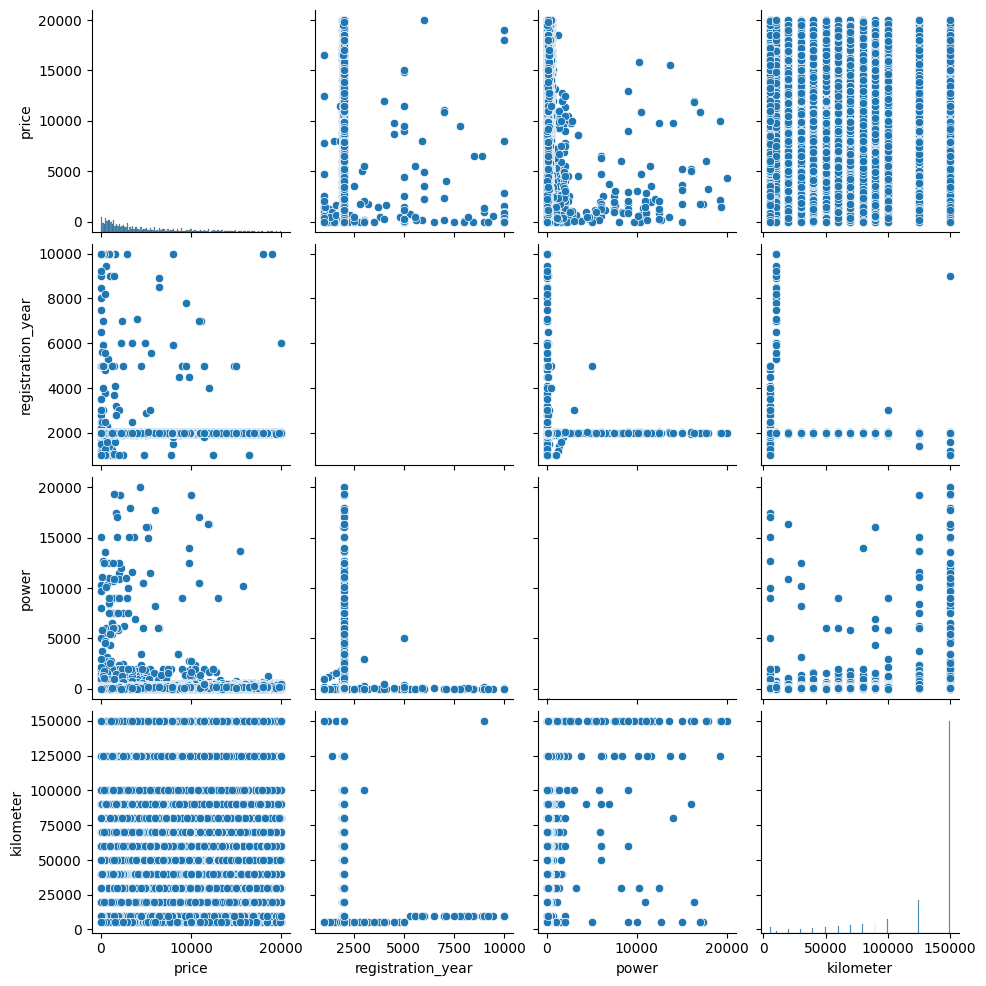

In [10]:
sns.pairplot(df);

В некоторых столбцах (`power, registration_year, price`) еще есть аномальные значения, надо их рассмотреть поближе.

### Дубликаты

In [11]:
print('Количество дубликатов:', sum(df.duplicated()))

Количество дубликатов: 45040


In [12]:
dubl_df = df.drop_duplicates()
df.shape[0] - dubl_df.shape[0]

45040

### Пропуски

In [13]:
dubl_df.loc[dubl_df['model'].isna()].shape

(18361, 10)

Модель автомобиля очень важный показатель.

In [14]:
dubl_df.loc[dubl_df['model'].isna(), 'model'] = 'unknown'

* repaired - не столь важный признак, потому заменим пропуски на `unknown`

In [15]:
dubl_df['repaired'] = dubl_df['repaired'].fillna('unknown')

### Аномалии

#### price

In [16]:
dubl_df['price'].value_counts().sort_index()

price
0        8904
1        1075
2          12
3           7
4           1
         ... 
19995       9
19997       1
19998       5
19999     252
20000     223
Name: count, Length: 3731, dtype: int64

Невероятное количество значений `0`. 

Цена - признак крайне важный, потому удалим строки с `0`.

In [17]:
dubl_df = dubl_df.loc[dubl_df['price'] != 0]

#### power

In [18]:
dubl_df['power'].value_counts().sort_index()

power
0        32972
1           26
2            9
3            9
4           26
         ...  
17932        1
19208        1
19211        1
19312        1
20000        1
Name: count, Length: 701, dtype: int64

In [19]:
dubl_df.loc[(dubl_df['power'] > 1000) | (dubl_df['power'] <= 0), 'power'].shape

(33253,)

Заменим неправдоподобные значения медианами среди автомобилей той же модели.

In [20]:
dubl_df.loc[(dubl_df['power'] > 1000) | (dubl_df['power'] <= 0), 'power'] = None

dubl_df['power'] = dubl_df['power'].fillna(dubl_df.groupby('model')['power'].transform('median'))
dubl_df = dubl_df.loc[~dubl_df['power'].isna()]

dubl_df['power'] = dubl_df['power'].astype('int64')

#### registration_year

In [21]:
dubl_df.loc[dubl_df['registration_year'] > 2020].shape

(83, 10)

In [22]:
dubl_df.loc[dubl_df['registration_year'] > 2020].head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
12946,49,NaN,5000,NaN,101,golf,5000,NaN,volkswagen,unknown
15870,1700,NaN,3200,NaN,106,unknown,5000,NaN,sonstige_autos,unknown
17271,700,NaN,9999,NaN,116,other,10000,NaN,opel,unknown
17346,6500,NaN,8888,NaN,106,unknown,10000,NaN,sonstige_autos,unknown
18259,300,NaN,2200,NaN,58,twingo,5000,NaN,renault,unknown
20159,1600,NaN,4100,NaN,106,unknown,5000,NaN,sonstige_autos,unknown
26382,150,NaN,3000,NaN,95,a_klasse,5000,NaN,mercedes_benz,unknown
26560,800,NaN,2066,NaN,125,zafira,5000,gasoline,opel,unknown
28390,799,NaN,9999,NaN,150,3er,10000,petrol,bmw,unknown
28965,18000,NaN,9999,NaN,95,a_klasse,10000,petrol,mercedes_benz,unknown


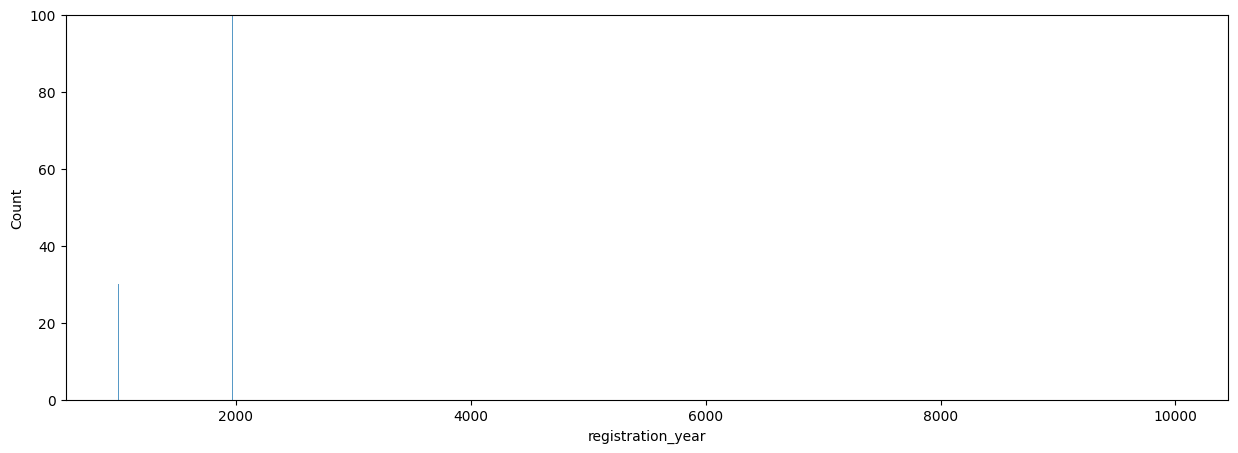

In [23]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.histplot(data=dubl_df, x='registration_year')
plt.ylim(0, 100);

Первая машина появилась в 1886 году, а значит раньше этой даты вообще не могло быть машин. Округлим до 1900 и посмотрим сколько машин попало в отрезок до.

In [24]:
dubl_df.loc[dubl_df['registration_year'] <= 1900].shape

(51, 10)

Строк с аномальным годом регистрации немного и у них пропущено достаточное количество других признаков, потому просто удалим.

In [25]:
dubl_df = dubl_df.loc[(dubl_df['registration_year'] <= 2020) & (dubl_df['registration_year'] > 1900)]

In [26]:
# КОД РЕВЬЮЕРА
dubl_df['registration_year'].min()

1910

#### vehicle_type, gearbox, fuel_type

Эти данные наиболее вероятно будут одинаковы в одинаковых моделях автомобилей. Заполним пропуски наиболее частым значением для модели.

In [27]:
dubl_df['vehicle_type'] = dubl_df['vehicle_type'].fillna(dubl_df
                                                         .groupby('model')['vehicle_type']
                                                         .transform(lambda x: x.value_counts().idxmax())
                                                        )

dubl_df['gearbox'] = dubl_df['gearbox'].fillna(dubl_df
                                               .groupby('model')['gearbox']
                                               .transform(lambda x: x.value_counts().idxmax())
                                              )

dubl_df['fuel_type'] = dubl_df['fuel_type'].fillna(dubl_df
                                                 .groupby('model')['fuel_type']
                                                 .transform(lambda x: x.value_counts().idxmax())
                                                )

Перед подсчетом потерь, снова проверим дубликаты, может они снова появились после замен.

In [28]:
print('Количество дубликатов:', sum(dubl_df.duplicated()))

Количество дубликатов: 5307


Избавимся от дубликатов.

In [29]:
dubl_df = dubl_df.drop_duplicates()

### Итоговые потери

In [30]:
print('Удалено данных:', f'{1-len(dubl_df) / len(df):.2%}', 'или', len(df) - len(dubl_df), 'строк')

Удалено данных: 16.76% или 59386 строк


### Подготовка к обучению

Для обучения нам понадобится `random_state`, создадим переменную для него.

In [32]:
random_state = 12345

Разделим данные

In [33]:
target = dubl_df['price']
features = dubl_df.drop('price', axis=1)

temp_x, features_test, temp_y, target_test = train_test_split(
    features, target, test_size=0.2, train_size=0.8, random_state=random_state)

features_train, features_valid, target_train, target_valid = train_test_split(
    temp_x, temp_y, test_size=0.25, random_state=random_state)

In [34]:
print(features_train.shape[0] / features.shape[0])
print(features_valid.shape[0] / features.shape[0])
print(features_test.shape[0] / features.shape[0])

0.5999972879793073
0.20000135601034635
0.20000135601034635


В столбце model много значений, преобразуем его методом `ordinal`.

In [35]:
features['model'].isna().sum()

0

In [36]:
encoder = OrdinalEncoder()
encoder.fit(features[['model']])

features_train['model'] = encoder.transform(features_train[['model']])
features_valid['model'] = encoder.transform(features_valid[['model']])
features_test['model'] = encoder.transform(features_test[['model']])

Остальные методом `OHE`.

In [37]:
features_train.columns

Index(['vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
       'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

In [38]:
cat_features = ['vehicle_type','gearbox', 'fuel_type', 'brand', 'repaired']

ohe_encoder = OneHotEncoder(drop='first', sparse=False)

features_temp = ohe_encoder.fit_transform(features_train[cat_features])
features_train[ohe_encoder.get_feature_names_out()] = features_temp
features_train.drop(cat_features, axis=1, inplace=True)

valid_temp = ohe_encoder.transform(features_valid[cat_features])
features_valid[ohe_encoder.get_feature_names_out()] = valid_temp
features_valid.drop(cat_features, axis=1, inplace=True)

test_temp = ohe_encoder.transform(features_test[cat_features])
features_test[ohe_encoder.get_feature_names_out()] = test_temp
features_test.drop(cat_features, axis=1, inplace=True)

In [39]:
features_train.head()

,registration_year,power,model,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
313061,2001,163,232.0,150000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
200324,1999,116,103.0,100000,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
346819,2003,102,149.0,150000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
912,2004,60,83.0,150000,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
325300,2006,60,83.0,20000,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Разделим данные

In [40]:
numeric = ['registration_year', 'power', 'model', 'kilometer']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [41]:
features_train.head()

,registration_year,power,model,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
313061,-0.292797,0.795469,1.576662,0.597422,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
200324,-0.555728,-0.076382,-0.172125,-0.708609,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
346819,-0.029866,-0.336083,0.451473,0.597422,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
912,0.101599,-1.115184,-0.443255,0.597422,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
325300,0.364531,-1.115184,-0.443255,-2.798259,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Обучение моделей

In [42]:
# Для удобства создадим функцию, которая будет возвращать RMSE
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

rmse_score = make_scorer(rmse, greater_is_better = False)

### Линейная регрессия

In [43]:
columns_lr = list(features_train.columns.values)
columns_lr.remove('model')

features_train_lr = features_train[columns_lr]
features_valid_lr = features_valid[columns_lr]
features_test_lr = features_test[columns_lr]

In [44]:
features_train_lr.columns

Index(['registration_year', 'power', 'kilometer', 'vehicle_type_convertible',
       'vehicle_type_coupe', 'vehicle_type_other', 'vehicle_type_sedan',
       'vehicle_type_small', 'vehicle_type_suv', 'vehicle_type_wagon',
       'gearbox_manual', 'fuel_type_electric', 'fuel_type_gasoline',
       'fuel_type_hybrid', 'fuel_type_lpg', 'fuel_type_other',
       'fuel_type_petrol', 'brand_audi', 'brand_bmw', 'brand_chevrolet',
       'brand_chrysler', 'brand_citroen', 'brand_dacia', 'brand_daewoo',
       'brand_daihatsu', 'brand_fiat', 'brand_ford', 'brand_honda',
       'brand_hyundai', 'brand_jaguar', 'brand_jeep', 'brand_kia',
       'brand_lada', 'brand_lancia', 'brand_land_rover', 'brand_mazda',
       'brand_mercedes_benz', 'brand_mini', 'brand_mitsubishi', 'brand_nissan',
       'brand_opel', 'brand_peugeot', 'brand_porsche', 'brand_renault',
       'brand_rover', 'brand_saab', 'brand_seat', 'brand_skoda', 'brand_smart',
       'brand_sonstige_autos', 'brand_subaru', 'brand_suzuki'

Посмотрим как справиться модель без изменения гиперпараметров.

In [45]:
model_lr = LinearRegression()
model_lr.fit(features_train_lr, target_train)

lr_pred = model_lr.predict(features_valid_lr)
rmse_lr = rmse(target_valid, lr_pred)

print('RMSE:', rmse_lr)

RMSE: 2984.50852112594


Переберем гиперпараметры и найдем лучшую комбинацию.

In [46]:
%%time

parameters = {'fit_intercept':[True, False], 'copy_X':[True, False]}
grid = GridSearchCV(model_lr, parameters, cv=5, scoring=rmse_score)
grid.fit(features_train_lr, target_train)

grid.best_params_

CPU times: total: 19.6 s
Wall time: 7.29 s


{'copy_X': True, 'fit_intercept': True}

Так как заказчику важны скорость обучения и скорость предсказания, посмотрим на них в лучшей модели по отдельности.

In [47]:
%%time

model_lr_tuned = LinearRegression(**grid.best_params_)
model_lr_tuned.fit(features_train_lr, target_train)

CPU times: total: 938 ms
Wall time: 398 ms


LinearRegression()

In [48]:
%%time

lr_pred = model_lr_tuned.predict(features_test_lr)

CPU times: total: 15.6 ms
Wall time: 16 ms


In [49]:
final_rmse_lr = rmse(target_test, lr_pred)
print(f'RMSE: {round(final_rmse_lr, 2)}') 

RMSE: 2981.67


### LightGBM

In [50]:
%%time

lgbm_model = lightgbm.LGBMRegressor(random_state=random_state)
lgbm_model.fit(features_train, target_train)

y_pred = lgbm_model.predict(features_valid)
rmse_lgbm = rmse(target_valid, y_pred)

print('RMSE:', rmse_lgbm)

RMSE: 1799.1225842479757
CPU times: total: 2.52 s
Wall time: 639 ms


In [51]:
%%time

lgbm_params = {"n_estimators": [1000, 1200],
               "max_depth": [12, 14]
              }

lgbm_model_tuned = GridSearchCV(lgbm_model, lgbm_params, cv=4, scoring=rmse)
lgbm_model_tuned.fit(features_train, target_train)

lgbm_model_tuned.best_params_

CPU times: total: 2min 48s
Wall time: 33.1 s


{'max_depth': 12, 'n_estimators': 1000}

In [52]:
%%time

lgbm_tuned = lightgbm.LGBMRegressor(**lgbm_model_tuned.best_params_, random_state=random_state)
lgbm_tuned.fit(features_train, target_train)

CPU times: total: 10.6 s
Wall time: 2.12 s


LGBMRegressor(max_depth=12, n_estimators=1000, random_state=12345)

In [53]:
%%time

lgbm_predict = lgbm_tuned.predict(features_test)

CPU times: total: 2.66 s
Wall time: 492 ms


In [54]:
rmse_lgbm = rmse(target_test, lgbm_predict)
print(f'RMSE: {rmse_lgbm}')

RMSE: 1691.10767794715


### Catboost

In [55]:
%%time

cbr_model = catboost.CatBoostRegressor(logging_level='Silent', random_state=random_state)
cbr_model.fit(features_train, target_train)

CPU times: total: 54.2 s
Wall time: 11.3 s


In [56]:
%%time

cbr_predict = cbr_model.predict(features_valid)

CPU times: total: 31.2 ms
Wall time: 25.9 ms


In [57]:
rmse_cbr = rmse(target_valid, cbr_predict)
print(f'RMSE: {rmse_cbr}')

RMSE: 1722.8774172477792


In [58]:
%%time

parameters_cb = {'iterations': [1000],
                 'learning_rate': [0.03, 0.1],
                 'depth': [6, 8],
                 'l2_leaf_reg': [1, 3]
                }

cbr_model = catboost.CatBoostRegressor(
    loss_function='RMSE', eval_metric = 'RMSE', logging_level='Silent', random_state=random_state
)
cbr_model_tuned = GridSearchCV(estimator=cbr_model, param_grid=parameters_cb, cv=4, scoring=rmse)

cbr_model_tuned.fit(features_train, target_train)
cbr_model_tuned.best_params_

CPU times: total: 27min 29s
Wall time: 5min 36s


{'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.03}

In [59]:
%%time
cbr_tuned = catboost.CatBoostRegressor(**cbr_model_tuned.best_params_, logging_level='Silent', random_state=random_state)
cbr_tuned.fit(features_train, target_train)

CPU times: total: 55.1 s
Wall time: 11 s


In [60]:
%%time
cbr_predict = cbr_tuned.predict(features_test)

CPU times: total: 31.2 ms
Wall time: 27 ms


In [61]:
rmse_cbr_tuned = rmse(target_test, cbr_predict)
print(f'RMSE: {rmse_cbr_tuned}')

RMSE: 1792.5850755498623


## Анализ моделей

In [62]:
print('LinearRegression:')
print(f'RMSE: {final_rmse_lr}, скорость предсказания: 18.1 ms, время обучения: 377 ms')
print()
print('LightGBM:')
print(f'RMSE: {rmse_lgbm}, скорость предсказания: 723 ms, время обучения: 4.17 s')
print()
print('Catboost:')
print(f'RMSE: {rmse_cbr_tuned}, скорость предсказания: 28.3 ms, время обучения: 15.2 s')
print('Catboost без изменения гиперпараметров:')
print(f'RMSE: {rmse_cbr}, скорость предсказания: 59.2 ms, время обучения: 14.7 s')

LinearRegression:
RMSE: 2981.6709014190587, скорость предсказания: 18.1 ms, время обучения: 377 ms

LightGBM:
RMSE: 1691.10767794715, скорость предсказания: 723 ms, время обучения: 4.17 s

Catboost:
RMSE: 1792.5850755498623, скорость предсказания: 28.3 ms, время обучения: 15.2 s
Catboost без изменения гиперпараметров:
RMSE: 1722.8774172477792, скорость предсказания: 59.2 ms, время обучения: 14.7 s


## Вывод

Исходя из требований заказчика, рекомендуем модель лучшую почти по всем показателям `LightGBM`:

* У этой модели самый низкий показатель RMSE и высокая скорость предсказания.